In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://isr.sri.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2019,9,1,0,0,0)
et=datetime.datetime(2019,9,2,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 100179810
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100179810
url: http://cedar.openmadrigal.org/madtoc/experiments3/2019/pfa/31aug19b
name: IPY27_Tracking_v03 - Long duration measurements in support of the International Polar Year
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2019
startmonth: 8
startday: 31
starthour: 18
startmin: 1
startsec: 5
endyear: 2019
endmonth: 9
endday: 1
endhour: 0
endmin: 30
endsec: 5
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1575945607
access: 0
Madrigal version: 3.0

id: 100179743
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100179743
url: http://cedar.openmadrigal.org/madtoc/experiments3/2019/pfa/01sep19a
name: MSWinds26.v03 - D-region E-region F-region local measurements
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2019
startmonth: 9
startday: 1
starth

In [5]:
print(expList[1])

id: 100179743
realUrl: http://cedar.openmadrigal.org/showExperiment/?experiment_list=100179743
url: http://cedar.openmadrigal.org/madtoc/experiments3/2019/pfa/01sep19a
name: MSWinds26.v03 - D-region E-region F-region local measurements
siteid: 10
sitename: CEDAR
instcode: 61
instname: Poker Flat IS Radar
startyear: 2019
startmonth: 9
startday: 1
starthour: 0
startmin: 30
startsec: 51
endyear: 2019
endmonth: 9
endday: 1
endhour: 19
endmin: 10
endsec: 4
isLocal: True
madrigalUrl: http://cedar.openmadrigal.org/
PI: Roger Varney
PIEmail: roger.varney@sri.com
uttimestamp: 1575947239
access: 0
Madrigal version: 3.0



In [6]:
fileList = maddat.getExperimentFiles(expList[1].id)
acfile=None
for file in fileList:
    if re.match('Alternating Code \(AC16-30\)',file.kindatdesc):
        acfile=file
        
filename=acfile.name
outfilename=acfile.name.split('/')[-1]
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [8]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

64016.0 14.04 90.0
64157.0 -154.3 77.5
64964.0 -34.69 66.09
65066.0 75.03 65.56


In [9]:
#find east and west beams
east=0
for i,d in enumerate(PFISR_data):
    if d['azm']==75.03:
        east=i
edat=PFISR_data[east]

west=0
for i,d in enumerate(PFISR_data):
    if d['azm']==-34.69:
        west=i
wdat=PFISR_data[west]

Text(0.5, 0.98, 'Alternating Code Data on 2019-09-01')

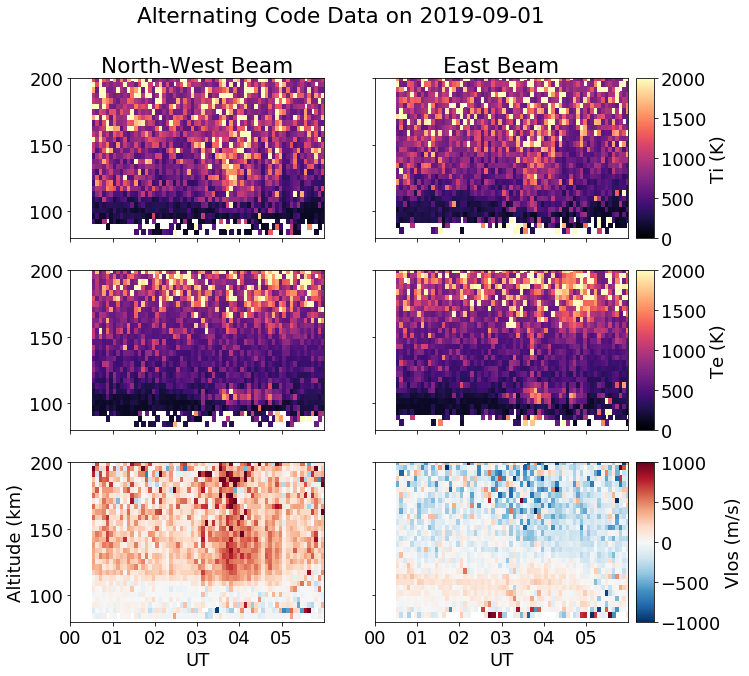

In [10]:
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(3,2,sharex=True,sharey=True)

ticlrs = axarr[0,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],wdat['ti'],vmin=0,vmax=2000,cmap='magma')
axarr[0,0].set_ylim([80,200])

teclrs = axarr[1,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],wdat['te'],vmin=0,vmax=2000,cmap='magma')
axarr[1,0].set_ylim([80,200])

voclrs = axarr[2,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],wdat['vo'],vmin=-1000,vmax=1000,cmap='RdBu_r')
axarr[2,0].set_ylim([80,200])

axarr[0,0].set_title('North-West Beam')

ticlrs = axarr[0,1].pcolormesh(mdates.date2num(edat['time']),edat['altitude'],edat['ti'],vmin=0,vmax=2000,cmap='magma')
axarr[0,1].set_ylim([80,200])

teclrs = axarr[1,1].pcolormesh(mdates.date2num(edat['time']),edat['altitude'],edat['te'],vmin=0,vmax=2000,cmap='magma')
axarr[1,1].set_ylim([80,200])

voclrs = axarr[2,1].pcolormesh(mdates.date2num(edat['time']),edat['altitude'],edat['vo'],vmin=-1000,vmax=1000,cmap='RdBu_r')
axarr[2,1].set_ylim([80,200])

axarr[0,1].set_title('East Beam')

axarr[-1,0].set_xlim([mdates.date2num(datetime.datetime(2019,9,1,0,0,0)),mdates.date2num(datetime.datetime(2019,9,1,6,0,0))])
axarr[-1,0].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,9,1,0,0,0)),mdates.date2num(datetime.datetime(2019,9,1,6,0,0)),1.00001/24.0))


axarr[-1,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,0].set_xlabel('UT')
axarr[-1,1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,1].set_xlabel('UT')
axarr[-1,0].set_ylabel('Altitude (km)')
#axarr[0].set_title('Alternating Code Temperatures on 2011-08-04')


box=axarr[0,1].get_position()
ticbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
ticb=plt.colorbar(ticlrs,cax=ticbarax)
ticb.set_label('Ti (K)')

box=axarr[1,1].get_position()
tecbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
tecb=plt.colorbar(teclrs,cax=tecbarax)
tecb.set_label('Te (K)')

box=axarr[2,1].get_position()
vocbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
vocb=plt.colorbar(voclrs,cax=vocbarax)
vocb.set_label('Vlos (m/s)')

fig.suptitle('Alternating Code Data on 2019-09-01')
